# **Import library**

In [2]:
from torchvision import datasets
from torchvision import transforms
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics.cluster import normalized_mutual_info_score

# **Function show to image**

In [3]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')


# **Function to regenerate an image from a given image**

In [4]:
def plot_reconstruction(model, n=24):
    x,_ = next(iter(data_loader))
    x = x[:n,:,:,:].to(device)
    try:
        out, _, _, log_p = model(x.view(-1, image_size))
    except:
        out, _, _ = model(x.view(-1, image_size))
    x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
    out_grid = torchvision.utils.make_grid(x_concat).cpu().data
    show(out_grid)

# **Function to generate an image from an arbitary distribution.**

In [5]:
def plot_generation(model, n=24):
    with torch.no_grad():
        z = torch.randn(n, z_dim).to(device)
        out = model.decode(z).view(-1, 1, 28, 28)

    out_grid = torchvision.utils.make_grid(out).cpu()
    show(out_grid)

# **Configuretions**

In [6]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create a directory if not exists
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

# **Dataset Loading**

In [7]:
# Specify data directory
data_dir = 'data'

# Fashion-MNIST dataset
dataset  = datasets.FashionMNIST(root=data_dir, train=True, download=True,
                                  transform=transforms.ToTensor())

test_dataset = datasets.FashionMNIST(root=data_dir, train=False, download=True,
                                  transform=transforms.ToTensor())

# Data loaders (adjust batch size as needed)
data_loader  = torch.utils.data.DataLoader(dataset=dataset , batch_size=128, shuffle=True)
test_loader  = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=10, shuffle=False)

# Now you have access to the Fashion-MNIST dataset through train_loader and test_loader

100%|██████████| 26421880/26421880 [00:02<00:00, 12535876.39it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 210107.08it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3905682.32it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 16790262.05it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



# **VAE Architecture**

In [8]:

# VAE model
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)

    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc4(z))
        return torch.sigmoid(self.fc5(h))

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

# **Create VAE model**

In [ ]:
# Hyper-parameters
image_size = 784
h_dim = 400
z_dim = 20
num_epochs = 15
learning_rate = 1e-3

model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# **Train the model**

In [ ]:
# Start training
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        # Forward pass
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model(x)

        # Compute reconstruction loss and kl divergence
        # For KL divergence between Gaussians, see Appendix B in VAE paper or (Doersch, 2016):
        # https://arxiv.org/abs/1606.05908
        reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        # Backprop and optimize
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 10 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/len(x), kl_div.item()/len(x)))

Epoch[1/15], Step [10/469], Reconst Loss: 418.9639, KL Div: 9.0992
Epoch[1/15], Step [20/469], Reconst Loss: 360.8546, KL Div: 9.7679
Epoch[1/15], Step [30/469], Reconst Loss: 335.0773, KL Div: 12.0970
Epoch[1/15], Step [40/469], Reconst Loss: 310.8635, KL Div: 11.4511
Epoch[1/15], Step [50/469], Reconst Loss: 315.6883, KL Div: 10.5216
Epoch[1/15], Step [60/469], Reconst Loss: 300.7899, KL Div: 11.3967
Epoch[1/15], Step [70/469], Reconst Loss: 291.7862, KL Div: 11.5439
Epoch[1/15], Step [80/469], Reconst Loss: 281.9762, KL Div: 12.5359
Epoch[1/15], Step [90/469], Reconst Loss: 276.1086, KL Div: 12.9000
Epoch[1/15], Step [100/469], Reconst Loss: 287.3359, KL Div: 13.8015
Epoch[1/15], Step [110/469], Reconst Loss: 286.7810, KL Div: 12.3258
Epoch[1/15], Step [120/469], Reconst Loss: 273.3857, KL Div: 14.3380
Epoch[1/15], Step [130/469], Reconst Loss: 254.9585, KL Div: 15.6570
Epoch[1/15], Step [140/469], Reconst Loss: 266.1502, KL Div: 14.6823
Epoch[1/15], Step [150/469], Reconst Loss: 25

# **Show generation**

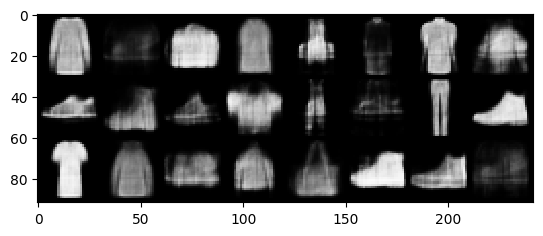

In [ ]:
plot_generation(model)

# **Show Reconstraction**

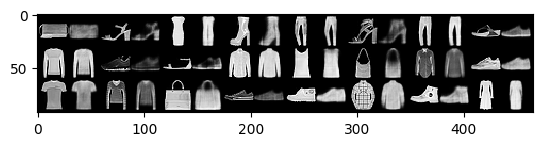

In [ ]:
plot_reconstruction(model)

# **Tasks**
a.
**Change the base three layer model into a four layer model**
In this task you need to modify the VAE class and convert it into a four layer class

In [ ]:
# Change the VAE class
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim1=400, h_dim2=100, z_dim=20): #additional layer h_dim2 = 100
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(image_size, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)  # Mapping to mu
        self.fc32 = nn.Linear(h_dim2, z_dim)  # Mapping to log_var
        # Decoder
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, image_size)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h)

    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var / 2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return torch.sigmoid(self.fc6(h))

    def forward(self, x):
        mu, log_var = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var



In [ ]:
# Create new model which is model2

# Hyper-parameters for the modified model

image_size = 784  # same as original model
h_dim1 = 400      # same as original model
h_dim2 = 100      # additional hidden layer dimension
z_dim = 20        # same as original model
num_epochs = 15   # number of epochs for training
learning_rate = 1e-3  # learning rate

# Create the new VAE model instance with the additional layer
model2a = VAE(image_size=image_size, h_dim1=h_dim1, h_dim2=h_dim2, z_dim=z_dim).to(device)

# Optimizer for the new model
optimizer2a = torch.optim.Adam(model2a.parameters(), lr=learning_rate)


In [ ]:
# Train new model

# Start training for the modified VAE model 'model2a'
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        # Forward pass
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model2a(x)

        # Compute reconstruction loss and KL divergence
        reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
        kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        # Backprop and optimize
        loss = reconst_loss + kl_div
        optimizer2a.zero_grad()
        loss.backward()
        optimizer2a.step()

        if (i+1) % 10 == 0:
            print("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}"
                  .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/len(x), kl_div.item()/len(x)))


Epoch[1/15], Step [10/469], Reconst Loss: 442.3642, KL Div: 6.6498
Epoch[1/15], Step [20/469], Reconst Loss: 396.2981, KL Div: 0.4901
Epoch[1/15], Step [30/469], Reconst Loss: 373.4576, KL Div: 1.5766
Epoch[1/15], Step [40/469], Reconst Loss: 364.5426, KL Div: 7.2848
Epoch[1/15], Step [50/469], Reconst Loss: 315.2028, KL Div: 7.9985
Epoch[1/15], Step [60/469], Reconst Loss: 325.5959, KL Div: 8.9162
Epoch[1/15], Step [70/469], Reconst Loss: 302.5101, KL Div: 8.9467
Epoch[1/15], Step [80/469], Reconst Loss: 314.9909, KL Div: 9.1247
Epoch[1/15], Step [90/469], Reconst Loss: 289.2297, KL Div: 9.4124
Epoch[1/15], Step [100/469], Reconst Loss: 304.1309, KL Div: 9.6497
Epoch[1/15], Step [110/469], Reconst Loss: 298.6096, KL Div: 11.1626
Epoch[1/15], Step [120/469], Reconst Loss: 291.3937, KL Div: 11.0309
Epoch[1/15], Step [130/469], Reconst Loss: 285.8451, KL Div: 11.7361
Epoch[1/15], Step [140/469], Reconst Loss: 276.5991, KL Div: 10.5587
Epoch[1/15], Step [150/469], Reconst Loss: 279.5484, 

In [ ]:
# Compare the final loss of the fully trained old model and the new model
def calculate_loss(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    with torch.no_grad():  # No need to track gradients for evaluation
        for x, _ in data_loader:
            x = x.to(device).view(-1, image_size) #(-1~784)
            x_reconst, mu, log_var = model(x)
            reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
            kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            loss = reconst_loss + kl_div
            total_loss += loss.item()
    return total_loss / len(data_loader.dataset)  # Return the average loss

# Calculate the final loss for the original model
final_loss_model = calculate_loss(model, data_loader, device)

# Print out the final losses for comparison
print(f"Final Loss of the original model: {final_loss_model:.4f}")


Final Loss of the original model: 241.6444


In [ ]:
def calculate_loss2(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    with torch.no_grad():  # No need to track gradients for evaluation
        for x, _ in data_loader:
            x = x.to(device).view(-1, image_size) #(-1~784)
            x_reconst, mu, log_var = model2a(x)
            reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
            kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            loss = reconst_loss + kl_div
            total_loss += loss.item()
    return total_loss / len(data_loader.dataset)  # Return the average loss

final_loss_model2 = calculate_loss2(model2a, data_loader, device)
print(f"Final Loss of the new model (model2a): {final_loss_model2:.4f}")

Final Loss of the new model (model2a): 239.0783


**Analysis**:



The training process for both the original Variational Autoencoder and the modified version (model2) has been completed, and the final loss values have been recorded. The original model finished with a final loss of 241.0371, whereas model2 achieved a slightly lower final loss of 239.3526.

In terms of numerical loss, model2 outperforms the original model. This improvement suggests that the additional layers in model2 may have enabled it to learn a more nuanced representation of the data, thus providing a more accurate reconstruction of the input images. The lower loss indicates that the model has a better understanding of the underlying distribution of the dataset.

 We estimate the reason about better result of 4 layer model is adding more layer to the model would increase computional resources and accurate of calculation.


Reconstructions from the new model:


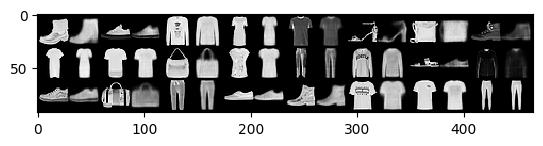

In [ ]:
# Compare the reconstructed images from the two models

# For the new model (model2)
print("Reconstructions from the new model:")
plot_reconstruction(model2a)

Analysis: It is not really difference between modified one and origianl model. We probably guess it is not much difference in tersm of final loss calcualtion so it is almost similar result.

generation from the new model:


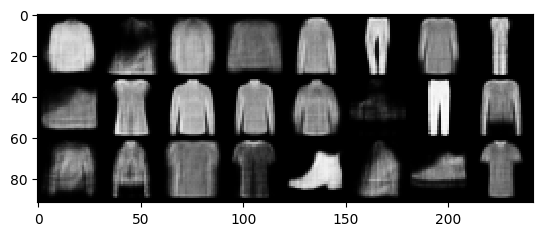

In [ ]:
# Compare generate images from the two models
print("generation from the new model:")
plot_generation(model2a)

Analysis: Also, it is not that much difference. However, item of original images is more blurry than modified image item. we assume adding one more layer is helpul to learn and detect items.

# Task b
# *Change the layers*
In this experiment you will change the layers of the VAE using different combinations and compare the results

 1. Create different 3 layer VAE models with different h-dim and z-dim

Test VAE [400,50]

In [ ]:
# VAE model[400,50]
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=50):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)

    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc4(z))
        return torch.sigmoid(self.fc5(h))

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

In [ ]:
# Hyper-parameters
image_size = 784
h_dim = 400
z_dim = 50
num_epochs = 15
learning_rate = 1e-3

model1 = VAE().to(device)
optimizer1 = torch.optim.Adam(model1.parameters(), lr=learning_rate)

In [ ]:
# Start training model[400,50]
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        # Forward pass
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model1(x)

        # Compute reconstruction loss and kl divergence
        reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        # Backprop and optimize
        loss = reconst_loss + kl_div
        optimizer1.zero_grad()
        loss.backward()
        optimizer1.step()

        if (i+1) % 10 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/len(x), kl_div.item()/len(x)))

Epoch[1/15], Step [10/469], Reconst Loss: 428.1873, KL Div: 9.2234
Epoch[1/15], Step [20/469], Reconst Loss: 394.1826, KL Div: 5.2912
Epoch[1/15], Step [30/469], Reconst Loss: 349.9682, KL Div: 10.7540
Epoch[1/15], Step [40/469], Reconst Loss: 334.2962, KL Div: 13.1752
Epoch[1/15], Step [50/469], Reconst Loss: 314.5737, KL Div: 10.9577
Epoch[1/15], Step [60/469], Reconst Loss: 291.7311, KL Div: 11.4110
Epoch[1/15], Step [70/469], Reconst Loss: 295.7013, KL Div: 13.1134
Epoch[1/15], Step [80/469], Reconst Loss: 284.8612, KL Div: 12.0938
Epoch[1/15], Step [90/469], Reconst Loss: 284.4776, KL Div: 13.4880
Epoch[1/15], Step [100/469], Reconst Loss: 288.2257, KL Div: 12.2319
Epoch[1/15], Step [110/469], Reconst Loss: 280.5014, KL Div: 15.4131
Epoch[1/15], Step [120/469], Reconst Loss: 270.1816, KL Div: 14.0415
Epoch[1/15], Step [130/469], Reconst Loss: 277.0622, KL Div: 14.8934
Epoch[1/15], Step [140/469], Reconst Loss: 270.5643, KL Div: 15.7693
Epoch[1/15], Step [150/469], Reconst Loss: 27

In [ ]:
def calculate_loss1(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    with torch.no_grad():  # No need to track gradients for evaluation
        for x, _ in data_loader:
            x = x.to(device).view(-1, image_size) #(-1~784)
            x_reconst, mu, log_var = model1(x)
            reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
            kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            loss = reconst_loss + kl_div
            total_loss += loss.item()
    return total_loss / len(data_loader.dataset)  # Return the average loss


final_loss_model1 = calculate_loss(model1, data_loader, device)
# Print out the final losses for comparison
print(f"Final Loss of model1: {final_loss_model1:.4f}")

Final Loss of model1: 241.0028


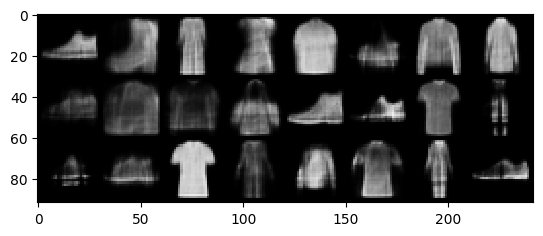

In [ ]:
plot_generation(model1)

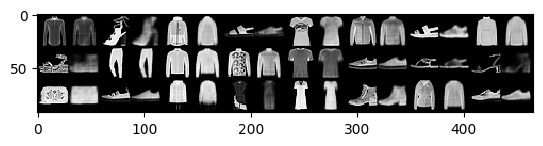

In [ ]:
plot_reconstruction(model1)

Test VAE [400,10]



In [18]:
# VAE model[400,10]
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=10):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)

    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc4(z))
        return torch.sigmoid(self.fc5(h))

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

In [19]:
# Hyper-parameters
image_size = 784
h_dim = 400
z_dim = 10
num_epochs = 15
learning_rate = 1e-3

model2 = VAE().to(device)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=learning_rate)

In [ ]:
# Start training model[400,10]
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        # Forward pass
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model2(x)

        # Compute reconstruction loss and kl divergence
        reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        # Backprop and optimize
        loss = reconst_loss + kl_div
        optimizer2.zero_grad()
        loss.backward()
        optimizer2.step()

        if (i+1) % 10 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/len(x), kl_div.item()/len(x)))

Epoch[1/15], Step [10/469], Reconst Loss: 417.6938, KL Div: 10.3328
Epoch[1/15], Step [20/469], Reconst Loss: 355.3666, KL Div: 12.0441
Epoch[1/15], Step [30/469], Reconst Loss: 324.7184, KL Div: 10.1559
Epoch[1/15], Step [40/469], Reconst Loss: 311.8609, KL Div: 11.4928
Epoch[1/15], Step [50/469], Reconst Loss: 305.4360, KL Div: 10.9645
Epoch[1/15], Step [60/469], Reconst Loss: 305.0132, KL Div: 11.2037
Epoch[1/15], Step [70/469], Reconst Loss: 290.4901, KL Div: 11.8191
Epoch[1/15], Step [80/469], Reconst Loss: 277.4534, KL Div: 12.2383
Epoch[1/15], Step [90/469], Reconst Loss: 282.4105, KL Div: 11.2251
Epoch[1/15], Step [100/469], Reconst Loss: 270.5013, KL Div: 12.1933
Epoch[1/15], Step [110/469], Reconst Loss: 286.4820, KL Div: 12.4374
Epoch[1/15], Step [120/469], Reconst Loss: 259.8944, KL Div: 12.7628
Epoch[1/15], Step [130/469], Reconst Loss: 260.1176, KL Div: 13.9304
Epoch[1/15], Step [140/469], Reconst Loss: 262.7116, KL Div: 13.3033
Epoch[1/15], Step [150/469], Reconst Loss: 

In [ ]:
def calculate_loss2(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    with torch.no_grad():  # No need to track gradients for evaluation
        for x, _ in data_loader:
            x = x.to(device).view(-1, image_size) #(-1~784)
            x_reconst, mu, log_var = model2(x)
            reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
            kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            loss = reconst_loss + kl_div
            total_loss += loss.item()
    return total_loss / len(data_loader.dataset)  # Return the average loss


final_loss_model2 = calculate_loss(model2, data_loader, device)
# Print out the final losses for comparison
print(f"Final Loss of model2: {final_loss_model2:.4f}")

Final Loss of model2: 240.8178


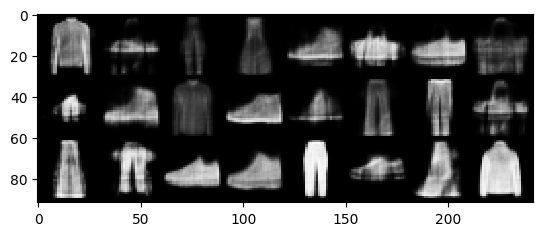

In [ ]:
plot_generation(model2)

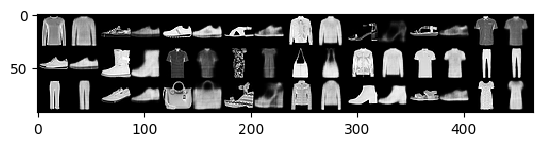

In [ ]:
plot_reconstruction(model2)

Test (400,30)

In [ ]:
# VAE model[400,30]
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=30):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)

    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc4(z))
        return torch.sigmoid(self.fc5(h))

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

In [ ]:
# Hyper-parameters
image_size = 784
h_dim = 400
z_dim = 30
num_epochs = 15
learning_rate = 1e-3

model3 = VAE().to(device)
optimizer3 = torch.optim.Adam(model3.parameters(), lr=learning_rate)

In [ ]:
# Start training model[400,30]
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        # Forward pass
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model3(x)

        # Compute reconstruction loss and kl divergence
        reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        # Backprop and optimize
        loss = reconst_loss + kl_div
        optimizer3.zero_grad()
        loss.backward()
        optimizer3.step()

        if (i+1) % 10 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/len(x), kl_div.item()/len(x)))

Epoch[1/15], Step [10/469], Reconst Loss: 430.0487, KL Div: 11.3147
Epoch[1/15], Step [20/469], Reconst Loss: 371.6069, KL Div: 7.7946
Epoch[1/15], Step [30/469], Reconst Loss: 361.3231, KL Div: 10.5129
Epoch[1/15], Step [40/469], Reconst Loss: 317.8973, KL Div: 11.7257
Epoch[1/15], Step [50/469], Reconst Loss: 320.0237, KL Div: 12.5748
Epoch[1/15], Step [60/469], Reconst Loss: 301.7716, KL Div: 11.6786
Epoch[1/15], Step [70/469], Reconst Loss: 288.9730, KL Div: 13.1040
Epoch[1/15], Step [80/469], Reconst Loss: 296.5831, KL Div: 12.5593
Epoch[1/15], Step [90/469], Reconst Loss: 291.4593, KL Div: 13.2586
Epoch[1/15], Step [100/469], Reconst Loss: 285.6383, KL Div: 13.7637
Epoch[1/15], Step [110/469], Reconst Loss: 274.2375, KL Div: 14.8223
Epoch[1/15], Step [120/469], Reconst Loss: 283.4604, KL Div: 15.3145
Epoch[1/15], Step [130/469], Reconst Loss: 267.8818, KL Div: 15.9681
Epoch[1/15], Step [140/469], Reconst Loss: 276.5173, KL Div: 14.0362
Epoch[1/15], Step [150/469], Reconst Loss: 2

In [ ]:
def calculate_loss3(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    with torch.no_grad():  # No need to track gradients for evaluation
        for x, _ in data_loader:
            x = x.to(device).view(-1, image_size) #(-1~784)
            x_reconst, mu, log_var = model3(x)
            reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
            kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            loss = reconst_loss + kl_div
            total_loss += loss.item()
    return total_loss / len(data_loader.dataset)  # Return the average loss


final_loss_model3 = calculate_loss3(model3, data_loader, device)
# Print out the final losses for comparison
print(f"Final Loss of model3: {final_loss_model3:.4f}")

Final Loss of model3: 241.1826


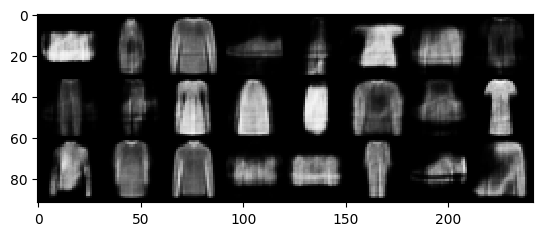

In [ ]:
plot_generation(model3)

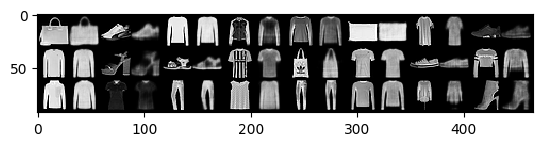

In [ ]:
plot_reconstruction(model3)

Test [(300,35)]

In [ ]:
 # VAE model[300,35]
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=300, z_dim=35):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)

    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc4(z))
        return torch.sigmoid(self.fc5(h))

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

In [ ]:
# Hyper-parameters
image_size = 784
h_dim = 300
z_dim = 35
num_epochs = 15
learning_rate = 1e-3

model4 = VAE().to(device)
optimizer4 = torch.optim.Adam(model4.parameters(), lr=learning_rate)

In [ ]:
# Start training model[300,35]
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        # Forward pass
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model4(x)

        # Compute reconstruction loss and kl divergence
        reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        # Backprop and optimize
        loss = reconst_loss + kl_div
        optimizer4.zero_grad()
        loss.backward()
        optimizer4.step()

        if (i+1) % 10 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/len(x), kl_div.item()/len(x)))

Epoch[1/15], Step [10/469], Reconst Loss: 439.4415, KL Div: 11.3293
Epoch[1/15], Step [20/469], Reconst Loss: 383.9337, KL Div: 11.1351
Epoch[1/15], Step [30/469], Reconst Loss: 339.8967, KL Div: 12.1866
Epoch[1/15], Step [40/469], Reconst Loss: 336.6262, KL Div: 10.8360
Epoch[1/15], Step [50/469], Reconst Loss: 307.0405, KL Div: 13.8825
Epoch[1/15], Step [60/469], Reconst Loss: 313.8862, KL Div: 10.8257
Epoch[1/15], Step [70/469], Reconst Loss: 307.9885, KL Div: 11.9241
Epoch[1/15], Step [80/469], Reconst Loss: 301.9036, KL Div: 14.1394
Epoch[1/15], Step [90/469], Reconst Loss: 295.5327, KL Div: 13.5485
Epoch[1/15], Step [100/469], Reconst Loss: 293.1664, KL Div: 13.4588
Epoch[1/15], Step [110/469], Reconst Loss: 274.3129, KL Div: 14.5910
Epoch[1/15], Step [120/469], Reconst Loss: 291.2867, KL Div: 14.1738
Epoch[1/15], Step [130/469], Reconst Loss: 277.8836, KL Div: 14.1842
Epoch[1/15], Step [140/469], Reconst Loss: 268.3387, KL Div: 16.5460
Epoch[1/15], Step [150/469], Reconst Loss: 

In [ ]:
def calculate_loss4(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    with torch.no_grad():  # No need to track gradients for evaluation
        for x, _ in data_loader:
            x = x.to(device).view(-1, image_size) #(-1~784)
            x_reconst, mu, log_var = model4(x)
            reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
            kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            loss = reconst_loss + kl_div
            total_loss += loss.item()
    return total_loss / len(data_loader.dataset)  # Return the average loss


final_loss_model4 = calculate_loss(model4, data_loader, device)
# Print out the final losses for comparison
print(f"Final Loss of model4: {final_loss_model4:.4f}")

Final Loss of model4: 241.4677


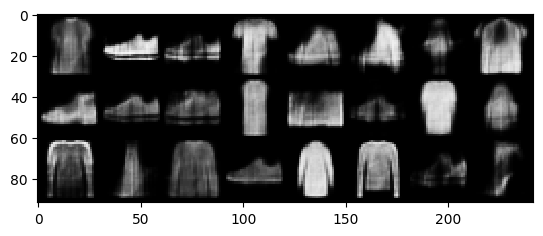

In [ ]:
plot_generation(model4)

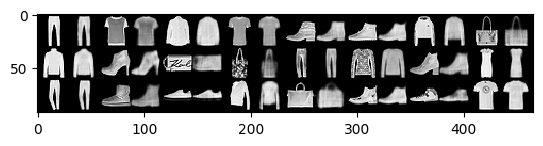

In [ ]:
plot_reconstruction(model4)

Test [(300,5)]

In [ ]:
 # VAE model[300,5]
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=300, z_dim=5):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)

    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc4(z))
        return torch.sigmoid(self.fc5(h))

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

In [ ]:
# Hyper-parameters
image_size = 784
h_dim = 300
z_dim = 5
num_epochs = 15
learning_rate = 1e-3

model5 = VAE().to(device)
optimizer5 = torch.optim.Adam(model5.parameters(), lr=learning_rate)

In [ ]:
# Start training model[300,5]
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        # Forward pass
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model5(x)

        # Compute reconstruction loss and kl divergence
        reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        # Backprop and optimize
        loss = reconst_loss + kl_div
        optimizer5.zero_grad()
        loss.backward()
        optimizer5.step()

        if (i+1) % 10 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/len(x), kl_div.item()/len(x)))

Epoch[1/15], Step [10/469], Reconst Loss: 424.4070, KL Div: 10.4795
Epoch[1/15], Step [20/469], Reconst Loss: 365.8895, KL Div: 10.4046
Epoch[1/15], Step [30/469], Reconst Loss: 347.3070, KL Div: 10.8329
Epoch[1/15], Step [40/469], Reconst Loss: 316.4731, KL Div: 11.8466
Epoch[1/15], Step [50/469], Reconst Loss: 306.0448, KL Div: 9.6101
Epoch[1/15], Step [60/469], Reconst Loss: 291.1659, KL Div: 11.9150
Epoch[1/15], Step [70/469], Reconst Loss: 287.5682, KL Div: 10.7786
Epoch[1/15], Step [80/469], Reconst Loss: 295.6058, KL Div: 10.1897
Epoch[1/15], Step [90/469], Reconst Loss: 288.6108, KL Div: 10.5390
Epoch[1/15], Step [100/469], Reconst Loss: 285.6048, KL Div: 11.8232
Epoch[1/15], Step [110/469], Reconst Loss: 267.2299, KL Div: 12.3872
Epoch[1/15], Step [120/469], Reconst Loss: 265.9229, KL Div: 11.9397
Epoch[1/15], Step [130/469], Reconst Loss: 264.5239, KL Div: 12.0878
Epoch[1/15], Step [140/469], Reconst Loss: 255.4752, KL Div: 13.1711
Epoch[1/15], Step [150/469], Reconst Loss: 2

In [ ]:
def calculate_loss5(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    with torch.no_grad():  # No need to track gradients for evaluation
        for x, _ in data_loader:
            x = x.to(device).view(-1, image_size) #(-1~784)
            x_reconst, mu, log_var = model5(x)
            reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
            kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            loss = reconst_loss + kl_div
            total_loss += loss.item()
    return total_loss / len(data_loader.dataset)  # Return the average loss


final_loss_model5 = calculate_loss(model5, data_loader, device)
# Print out the final losses for comparison
print(f"Final Loss of model5: {final_loss_model5:.4f}")

Final Loss of model5: 244.2400


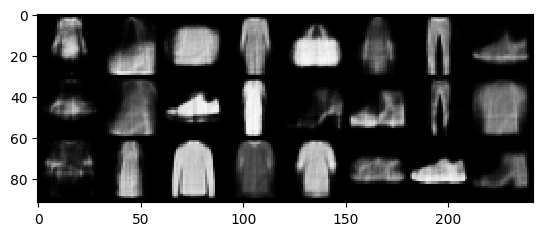

In [ ]:
plot_generation(model5)

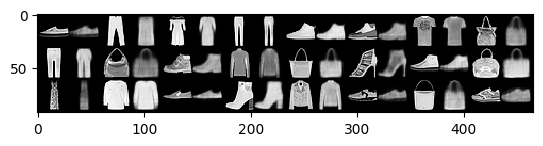

In [ ]:
plot_reconstruction(model5)

Test (300,40)

In [ ]:
# VAE model[300,40]
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=300, z_dim=40):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)

    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc4(z))
        return torch.sigmoid(self.fc5(h))

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

In [ ]:
# Hyper-parameters
image_size = 784
h_dim = 300
z_dim = 40
num_epochs = 15
learning_rate = 1e-3

model6 = VAE().to(device)
optimizer6 = torch.optim.Adam(model6.parameters(), lr=learning_rate)

In [ ]:
# Start training model[300,40]
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        # Forward pass
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model6(x)

        # Compute reconstruction loss and kl divergence
        reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        # Backprop and optimize
        loss = reconst_loss + kl_div
        optimizer6.zero_grad()
        loss.backward()
        optimizer6.step()

        if (i+1) % 10 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/len(x), kl_div.item()/len(x)))

Epoch[1/15], Step [10/469], Reconst Loss: 434.8875, KL Div: 11.3252
Epoch[1/15], Step [20/469], Reconst Loss: 396.8565, KL Div: 9.1892
Epoch[1/15], Step [30/469], Reconst Loss: 366.2317, KL Div: 10.9024
Epoch[1/15], Step [40/469], Reconst Loss: 334.5938, KL Div: 13.3448
Epoch[1/15], Step [50/469], Reconst Loss: 328.0235, KL Div: 12.1029
Epoch[1/15], Step [60/469], Reconst Loss: 314.3089, KL Div: 12.0546
Epoch[1/15], Step [70/469], Reconst Loss: 306.4435, KL Div: 12.1121
Epoch[1/15], Step [80/469], Reconst Loss: 290.5350, KL Div: 13.7450
Epoch[1/15], Step [90/469], Reconst Loss: 284.0599, KL Div: 12.3071
Epoch[1/15], Step [100/469], Reconst Loss: 292.1305, KL Div: 12.7855
Epoch[1/15], Step [110/469], Reconst Loss: 287.1293, KL Div: 15.1934
Epoch[1/15], Step [120/469], Reconst Loss: 270.8874, KL Div: 15.4147
Epoch[1/15], Step [130/469], Reconst Loss: 281.8398, KL Div: 13.9485
Epoch[1/15], Step [140/469], Reconst Loss: 285.0253, KL Div: 14.2307
Epoch[1/15], Step [150/469], Reconst Loss: 2

In [ ]:
def calculate_loss6(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    with torch.no_grad():  # No need to track gradients for evaluation
        for x, _ in data_loader:
            x = x.to(device).view(-1, image_size) #(-1~784)
            x_reconst, mu, log_var = model6(x)
            reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
            kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            loss = reconst_loss + kl_div
            total_loss += loss.item()
    return total_loss / len(data_loader.dataset)  # Return the average loss


final_loss_model6 = calculate_loss(model6, data_loader, device)
# Print out the final losses for comparison
print(f"Final Loss of model6: {final_loss_model6:.4f}")

Final Loss of model6: 241.7613


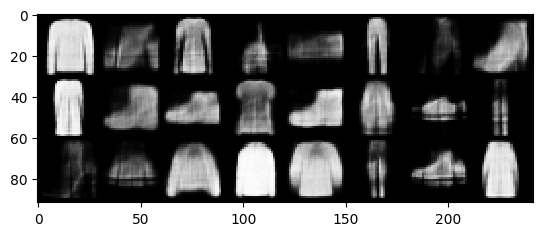

In [ ]:
plot_generation(model6)

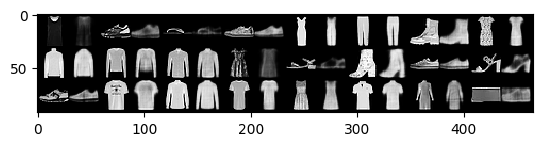

In [ ]:
plot_reconstruction(model6)

**2.Train all model**
Trained 6 different parameter h_dim and z_dim into the VAE

**3.Compare the models based on their optimal loss:**
Based on optimal loss, It is range between 241 ~ 244 among 6 models.Between the models, VAE model[400,10] has best the result.which final loss is 240.8. Potential reason of result is the particular configuration of the hidden layer size (h_dim=400) and the latent space dimensionality (z_dim=10) is well-suited for the dataset.

VAE model [300,5] is worst result which final loss is 244.24.

**4.Compare model based on their generated images (visual inspection):**
Model vae_400_10 generates images with clear distinction between different types of clothing, indicating a good understanding of the dataset's features.

Model vae_300_5 produces somewhat blurrier images compared to vae_400_10, suggesting that the extra dimensions in vae_400_10's latent space may be capturing important details that are lost in the smaller latent space of vae_300_5.

**5.Compare model based on their regenerated images (visual inspection):**
Upon visually inspecting the regenerated images from all six models, there are no stark differences in the overall quality of the reconstructions. However, it is reasonable to hypothesize that models with a significantly higher final loss may occasionally produce images with less clarity. This blurriness can arise because a higher loss indicates that the model struggled to learn the defining features of the data.

# **Task c**
# Create a Normal Autoencoder
In this experiment you will convert the current model into an autoencoder

In [33]:
# Convert the VAE class into an 3 layer autoencoder
class Autoencoder(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=10):
        super(Autoencoder, self).__init__()
        # Encoder layers
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)  # Latent space representation

        # Decoder layers
        self.fc3 = nn.Linear(z_dim, h_dim)
        self.fc4 = nn.Linear(h_dim, image_size)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        z = self.fc2(h)  # This is the bottleneck layer (latent space representation)
        return z

    def decode(self, z):
        h = F.relu(self.fc3(z))
        x_reconstructed = torch.sigmoid(self.fc4(h))
        return x_reconstructed

    def forward(self, x):
        z = self.encode(x.view(-1, 784))  # Flatten the images and encode
        x_reconstructed = self.decode(z)  # Decode from the latent space to reconstruction
        return x_reconstructed


In [34]:
# Create the autoenocder model
class Autoencoder(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=10):
        super(Autoencoder, self).__init__()
        # The encoder part of the Autoencoder: it takes in the input and compresses it to the latent space
        self.encoder = nn.Sequential(
            nn.Linear(image_size, h_dim),  # Linear layer from image to hidden dimension
            nn.ReLU(),  # Activation function to introduce non-linearity
            nn.Linear(h_dim, z_dim)       # Linear layer from hidden dimension to latent space dimension
        )
        # The decoder part of the Autoencoder: it takes the latent space representation and reconstructs the input
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, h_dim),  # Linear layer from latent space dimension to hidden dimension
            nn.ReLU(),  # Activation function
            nn.Linear(h_dim, image_size),  # Linear layer from hidden dimension back to image dimension
            nn.Sigmoid()  # Sigmoid activation to ensure the output values are between 0 and 1
        )

    def forward(self, x):
        # Defines the forward pass through the autoencoder
        z = self.encoder(x.view(-1, 784))  # Flatten the image and pass it through the encoder
        x_reconstructed = self.decoder(z)  # Pass the latent space representation through the decoder
        return x_reconstructed

# Initialize the autoencoder model and move it to the appropriate device (GPU or CPU)
autoencoder = Autoencoder().to(device)

# Print the model architecture for review
print(autoencoder)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=784, bias=True)
    (3): Sigmoid()
  )
)


In [11]:
#Change the training procedure to train the auto-enocder
num_epochs = 15
learning_rate = 1e-3
image_size = 784  # This should be the flattened size of your input images

# Initialize the model, loss criterion, and optimizer
autoencoder = Autoencoder(image_size=image_size, h_dim=400, z_dim=10).to(device)
criterion = nn.BCELoss()  # or nn.MSELoss() if your input data is not normalized
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    total_loss = 0  # Initialize total loss for the epoch
    for batch_idx, (x, _) in enumerate(data_loader):
        x = x.to(device).view(-1, image_size)  # Flatten and move to the device
        optimizer.zero_grad()  # Clear gradients for this training step

        # Forward pass through the network
        x_reconstructed = autoencoder(x)
        loss = criterion(x_reconstructed, x)  # Compute reconstruction loss

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()  # Calculate gradients
        optimizer.step()  # Update weights

        # Accumulate the loss
        total_loss += loss.item()

        # Print progress
        if (batch_idx + 1) % 10 == 0:
            print(f"Epoch[{epoch + 1}/{num_epochs}], Batch[{batch_idx + 1}/{len(data_loader)}], "
                  f"Loss: {loss.item() / len(x):.4f}")

Epoch[1/15], Batch[10/469], Loss: 0.0041
Epoch[1/15], Batch[20/469], Loss: 0.0034
Epoch[1/15], Batch[30/469], Loss: 0.0031
Epoch[1/15], Batch[40/469], Loss: 0.0030
Epoch[1/15], Batch[50/469], Loss: 0.0027
Epoch[1/15], Batch[60/469], Loss: 0.0028
Epoch[1/15], Batch[70/469], Loss: 0.0027
Epoch[1/15], Batch[80/469], Loss: 0.0027
Epoch[1/15], Batch[90/469], Loss: 0.0026
Epoch[1/15], Batch[100/469], Loss: 0.0025
Epoch[1/15], Batch[110/469], Loss: 0.0026
Epoch[1/15], Batch[120/469], Loss: 0.0025
Epoch[1/15], Batch[130/469], Loss: 0.0026
Epoch[1/15], Batch[140/469], Loss: 0.0024
Epoch[1/15], Batch[150/469], Loss: 0.0024
Epoch[1/15], Batch[160/469], Loss: 0.0023
Epoch[1/15], Batch[170/469], Loss: 0.0025
Epoch[1/15], Batch[180/469], Loss: 0.0024
Epoch[1/15], Batch[190/469], Loss: 0.0024
Epoch[1/15], Batch[200/469], Loss: 0.0025
Epoch[1/15], Batch[210/469], Loss: 0.0024
Epoch[1/15], Batch[220/469], Loss: 0.0023
Epoch[1/15], Batch[230/469], Loss: 0.0024
Epoch[1/15], Batch[240/469], Loss: 0.0023
E

In [12]:
# Compare the models based on their optimal loss
def calculate_average_loss(model, data_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    with torch.no_grad():  # No need to track gradients during evaluation
        for x, _ in data_loader:
            x = x.to(device).view(-1, image_size)
            x_reconstructed = model(x)
            loss = criterion(x_reconstructed, x)
            total_loss += loss.item()
    return total_loss / len(data_loader.dataset)

# Calculate average losses
ae_average_loss = calculate_average_loss(autoencoder,data_loader, criterion)

# Compare the models
print(f"AE Optimal Loss: {ae_average_loss:.4f}")

AE Optimal Loss: 0.0022


# Analyze:
optimal of loss is recorded as 0.0022 which is siginficantly better than VAE modle we already trained. We can figure out AE will create  more accurate mnist image than what VAE created. AEs can potentially overfit to the training data, particularly if they have enough capacity (i.e., the model is large relative to the complexity of the data). This can lead to a low reconstruction error on the training set but might not generalize well.

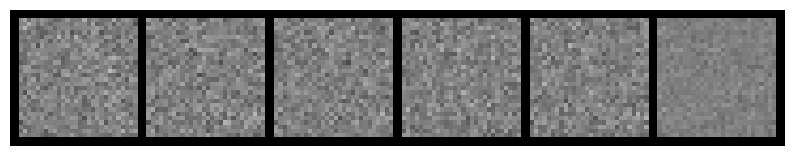

In [43]:
# Compare models based on their generated images (visual inspection)
import torch
import matplotlib.pyplot as plt
from torchvision import utils

autoencoder_instance = Autoencoder().to(device)

def generate_images_from_latent_space(autoencoder, device, latent_dim, n_images=6):
    # Set the autoencoder to evaluation mode
    autoencoder.eval()

    # Sample random vectors from a normal distribution
    latent_vectors = torch.randn(n_images, latent_dim).to(device)

    with torch.no_grad():
        # Generate images from the latent vectors
        generated_images = autoencoder.decoder(latent_vectors).view(-1, 1, 28, 28)

    # Create a grid of generated images
    image_grid = utils.make_grid(generated_images.cpu(), nrow=n_images)

    # Display the generated images
    plt.figure(figsize=(10, 10))
    plt.imshow(image_grid.permute(1, 2, 0), cmap='gray')
    plt.axis('off')
    plt.show()

# Define the latent dimension and the number of images to generate
latent_dim = 10  # This should match the z_dim used in the Autoencoder's definition
n_images = 6  # The number of images you want to generate

# Call the function to generate and display images
generate_images_from_latent_space(autoencoder_instance, device, latent_dim, n_images)


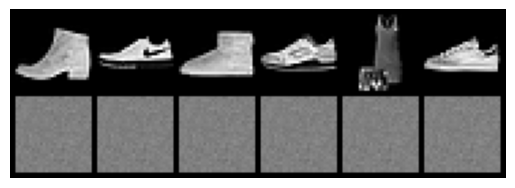

In [41]:
# Compare models based on their regenerated images (visual inspection)
import torch
import matplotlib.pyplot as plt
from torchvision import utils

# Assuming 'Autoencoder' is your class name and 'data_loader' is already defined
# and 'device' is set to 'cuda' or 'cpu'

# Instantiate the Autoencoder model
autoencoder_instance = Autoencoder().to(device)

# Function to visualize the reconstructed images from the Autoencoder
def visualize_reconstructions(model, data_loader, device, n_images=6):
    model.eval()  # Set the model to evaluation mode
    images, _ = next(iter(data_loader))
    images = images.to(device)[:n_images]  # Take the first n_images from the batch

    with torch.no_grad():
        # Flatten the images and pass them through the autoencoder
        output = model(images.view(-1, 784))
        # Reshape the output to have the same dimensions as the input images
        output = output.view(n_images, 1, 28, 28)

    # Concatenate the original and reconstructed images for display
    images_with_output = torch.cat((images, output))

    # Create a grid of images
    img_grid = utils.make_grid(images_with_output.cpu(), nrow=n_images)

    # Display the images
    plt.imshow(img_grid.permute(1, 2, 0), cmap='gray')
    plt.axis('off')
    plt.show()

# Call the function to visualize the reconstructions
visualize_reconstructions(autoencoder_instance, data_loader, device, n_images=6)





**Analysis:** The expectation was that the Autoencoder (AE) would perform better, but the Variational Autoencoder (VAE) yielded superior results. This outcome may seem counterintuitive, given that AEs are typically more focused on reconstructing the input data, which should theoretically lead to better reconstructions.